In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00


In [2]:
use_kitti = True

if use_kitti:
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_selection.zip
  !unzip /content/data_depth_selection.zip
else:
  !wget http://diode-dataset.s3.amazonaws.com/val.tar.gz
  !tar --gunzip --extract --file=val.tar.gz

Streaming output truncated to the last 5000 lines.
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000006.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000007.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000008.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000009.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000010.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000011.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000012.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000013.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000014.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000015.png  
 extracting: depth_selection/test_depth_prediction_anonymous/image/0000000016.png  
 extracting: depth_select

In [3]:
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from torchsummary import summary
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization as quantization
import copy

In [4]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 131MB/s]


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [5]:
summary(midas, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  Conv2dSameExport-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
          Identity-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 24, 128, 128]             768
       BatchNorm2d-9         [-1, 24, 128, 128]              48
         Identity-10         [-1, 24, 128, 128]               0
DepthwiseSeparableConv-11         [-1, 24, 128, 128]               0
           Conv2d-12        [-1, 144, 128, 128]           3,456
      BatchNorm2d-13        [-1, 144, 128, 128]             288
            ReLU6-14        [-1, 1

In [6]:
# Dataset for KITTI images
class CustomDepthDataset(Dataset):
    def __init__(self, image_folder, groundtruth_folder, transform=None, target_transform=None):
        self.image_folder = image_folder
        self.groundtruth_folder = groundtruth_folder
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = os.listdir(image_folder)
        self.groundtruth_files = os.listdir(groundtruth_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        gt_name = os.path.join(self.groundtruth_folder, self.groundtruth_files[idx])

        # Preprocess input and ground truths
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        groundtruth = cv2.imread(gt_name, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            groundtruth = self.target_transform(groundtruth)
        return image, groundtruth

# Transforms for inputs and ground truths
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)), # 384, 512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

groundtruth_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)), # 384, 512
    transforms.ToTensor(),
])

# Instantiate Dataset
data_root = "/content/depth_selection/val_selection_cropped"
image_folder_path = os.path.join(data_root, "image")
groundtruth_folder_path = os.path.join(data_root, "groundtruth_depth")
custom_dataset = CustomDepthDataset(
    image_folder_path, groundtruth_folder_path,
    transform=image_transform, target_transform=groundtruth_transform
)

# Split train/val
dataset_size = len(custom_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

In [8]:
# Compute MAE, RMSE for batch
def compute_accuracy_batch(predictions, groundtruth_data):
    predictions_flat = predictions.flatten()
    groundtruth_flat = groundtruth_data.flatten()
    mae = mean_absolute_error(groundtruth_flat, predictions_flat)
    rmse = np.sqrt(mean_squared_error(groundtruth_flat, predictions_flat))
    return mae, rmse

# Compute inference on dataset
def compute_accuracy(model, data_loader, device):
    model.eval()
    total_mae = 0.0
    total_rmse = 0.0
    total_samples = 0

    with tqdm(total=len(data_loader), desc="Inference Progress", unit="batch") as pbar:
        for batch_idx, (images, groundtruths) in enumerate(data_loader):
            # Get predictions and loss for batch
            images, groundtruths = images.to(device), groundtruths.to(device)
            predictions = model(images)
            mae, rmse = compute_accuracy_batch(predictions.cpu().detach().numpy(), groundtruths.cpu().detach().numpy())
            batch_size = images.size(0)
            total_mae += mae * batch_size
            total_rmse += rmse * batch_size
            total_samples += batch_size

            # Plot example input and output from first batch
            if batch_idx == 0:
                plot_example(images[0], predictions[0])
            pbar.update(1)

    # Calculate average loss over entire dataset
    average_mae = total_mae / total_samples
    average_rmse = total_rmse / total_samples
    return average_mae, average_rmse

# Plot function for input/output
def plot_example(image, depth_map):
    image = image.cpu().detach().numpy().transpose((1, 2, 0))
    depth_map = depth_map.cpu().detach().numpy().squeeze()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap='viridis')
    plt.title('Depth Map Prediction')
    plt.show()

# Instantiate data loaders
batch_size = 2
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [9]:
# Fine tune function - does not work
def fine_tune_model(model, train_loader, val_loader, num_epochs=3, learning_rate=0.001, device=device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    # For each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # For each batch, get prediction in forward pass, calculate loss, and update weights in backwards pass
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for images, groundtruths in train_loader:
                images, groundtruths = images.to(device), groundtruths.to(device)
                optimizer.zero_grad()
                predictions = model(images)
                loss = criterion(predictions, groundtruths)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)

        # Compute average train loss for epoch, and evaluate on val data
        average_train_loss = running_loss / len(train_loader)
        val_mae, val_rmse = compute_accuracy(model, val_loader, device)
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation MAE: {val_mae:.4f}, Validation RMSE: {val_rmse:.4f}')
    print('Fine-tuning complete.')
    return model

Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


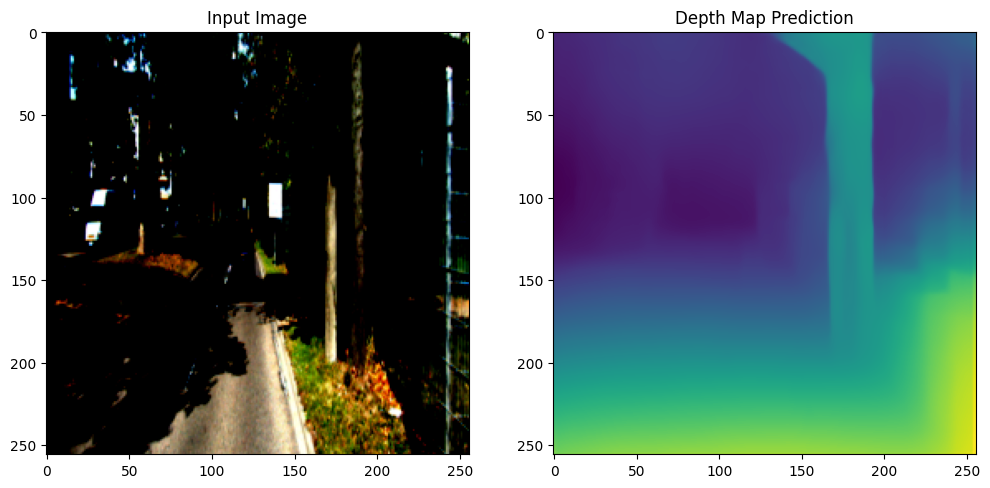

Inference Progress: 100%|██████████| 100/100 [01:05<00:00,  1.53batch/s]

Mean Absolute Error (MAE): 408.199885559082
Root Mean Squared Error (RMSE): 482.88056518554686


In [10]:
# Fine Tune Full Model
#midas_full_finetuned = fine_tune_model(midas, train_loader, val_loader, num_epochs=1, learning_rate=0.001)

# Full Model Inference
average_mae, average_rmse = compute_accuracy(midas, val_loader, device)
print(f"Mean Absolute Error (MAE): {average_mae}")
print(f"Root Mean Squared Error (RMSE): {average_rmse}")

In [15]:
# Channel pruning function
def prune_model(model, percent):
    # Find conv2d layer magnitudes and sort lowest to highest (lower = less important channel), then truncate list based on prune percentage
    layer_magnitudes = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.modules.Conv2d):
            magnitude = module.weight.abs().mean().item()
            layer_magnitudes.append((name, magnitude))

    sorted_layers = sorted(layer_magnitudes, key=lambda x: x[1])
    prune_percent = percent
    num_layers_to_prune = int(len(sorted_layers) * prune_percent)

    # Prune layers in list using torch
    for layer_name, _ in sorted_layers[:num_layers_to_prune]:
        #delattr(model, layer_name)
        layer = dict(model.named_modules())[layer_name]
        parameters_to_prune = (f'{layer_name}.weight',)
        prune.l1_unstructured(module=layer, name='weight', amount=1.0)

# Quantization function - does not work
def quantize_model(model):
    # Calibrate model
    model.eval()
    example_input = torch.randn(1, 3, 256, 256)

    # Script and fuse conv and batch norm layers
    scripted_model = torch.jit.script(model)
    fused_scripted_model = torch.quantization.fuse_modules(scripted_model, [['conv', 'bn']])

    # Quantize using torch
    quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Conv2d, torch.nn.BatchNorm2d}, dtype=torch.qint8).to(device)
    return quantized_model

# Calibrate model helper - not used since quantization failed
def calibrate(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            _ = model(data)

Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


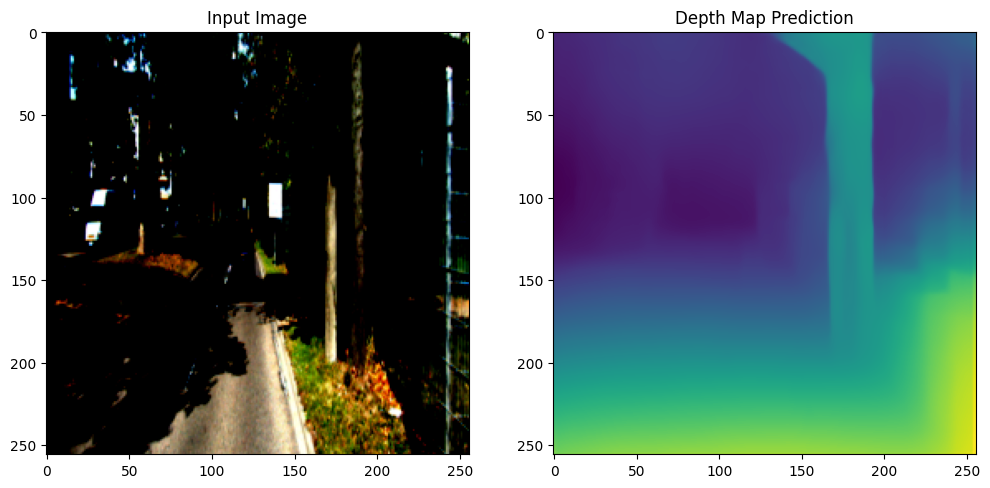

Inference Progress: 100%|██████████| 100/100 [01:14<00:00,  1.35batch/s]


Pruning Ratio: 0.0
Mean Absolute Error (MAE): 408.199885559082
Root Mean Squared Error (RMSE): 482.88056518554686



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


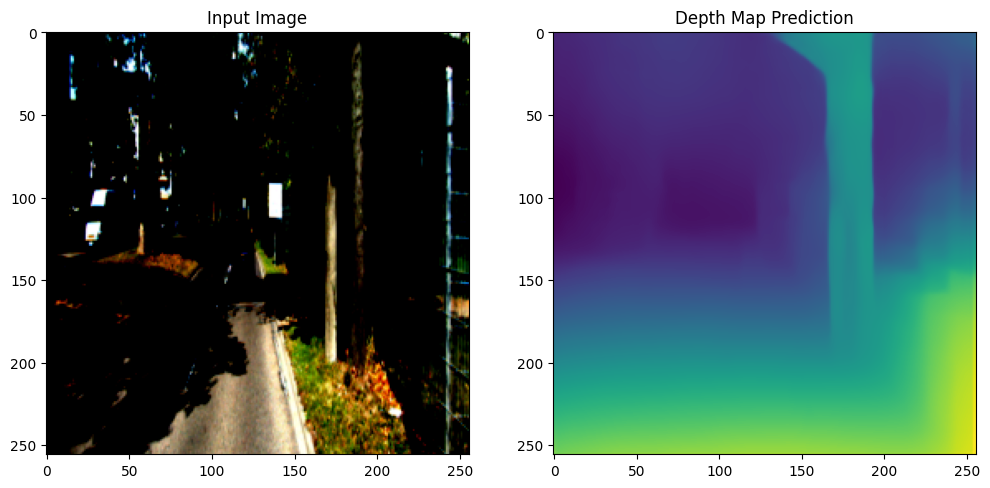

Inference Progress: 100%|██████████| 100/100 [01:25<00:00,  1.18batch/s]


Pruning Ratio: 0.02
Mean Absolute Error (MAE): 408.199885559082
Root Mean Squared Error (RMSE): 482.88056518554686



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


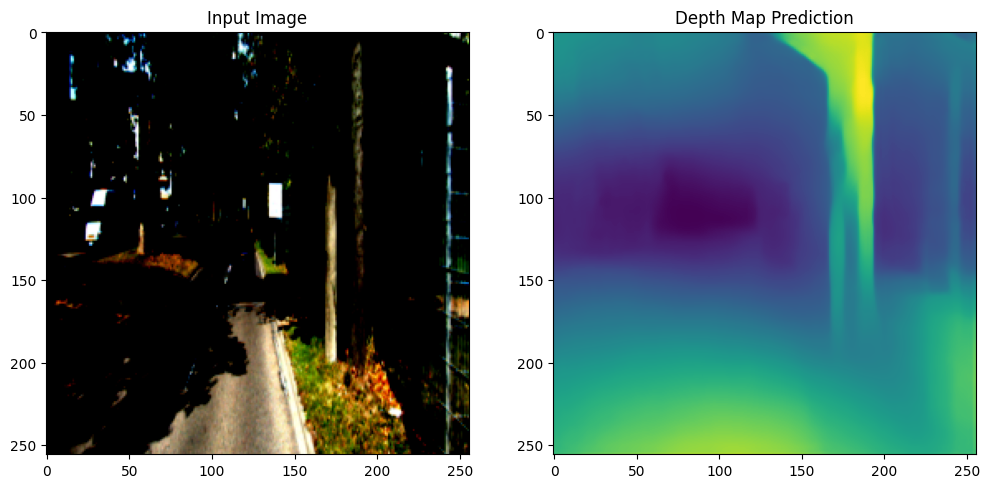

Inference Progress: 100%|██████████| 100/100 [01:22<00:00,  1.21batch/s]


Pruning Ratio: 0.04
Mean Absolute Error (MAE): 166.50465438842772
Root Mean Squared Error (RMSE): 184.50995574951173



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06batch/s]


Pruning Ratio: 0.06
Mean Absolute Error (MAE): 165.24328521728515
Root Mean Squared Error (RMSE): 177.06543823242188



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


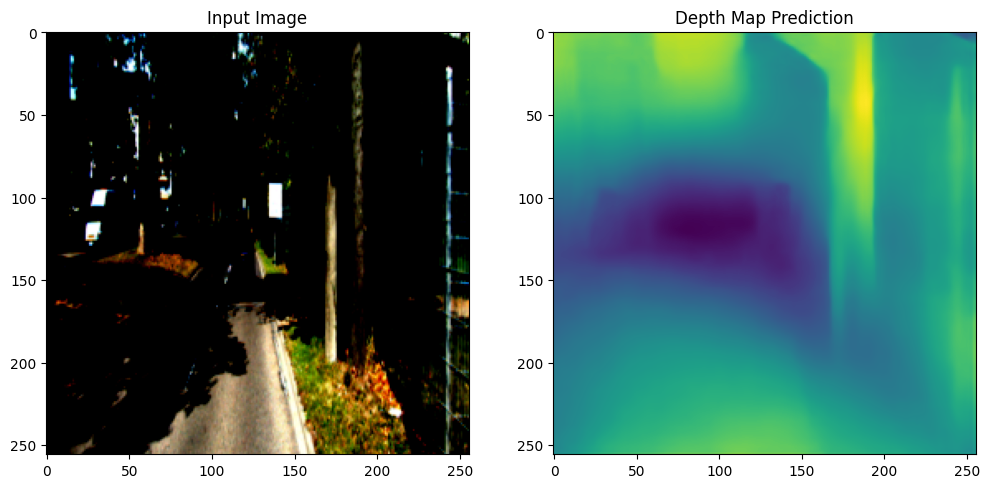

Inference Progress: 100%|██████████| 100/100 [01:25<00:00,  1.17batch/s]


Pruning Ratio: 0.08
Mean Absolute Error (MAE): 170.5474397277832
Root Mean Squared Error (RMSE): 178.2444583129883



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


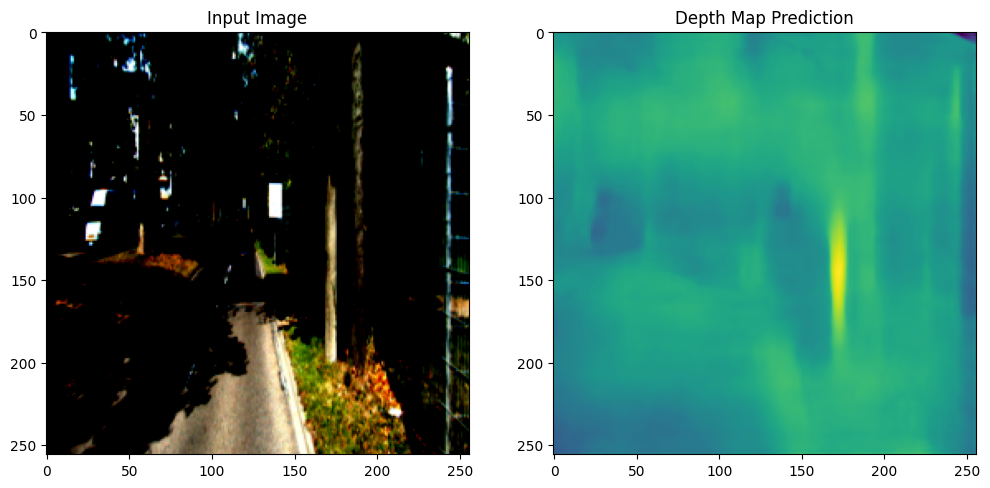

Inference Progress: 100%|██████████| 100/100 [01:33<00:00,  1.07batch/s]


Pruning Ratio: 0.1
Mean Absolute Error (MAE): 114.23396965026855
Root Mean Squared Error (RMSE): 114.83624221801757



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


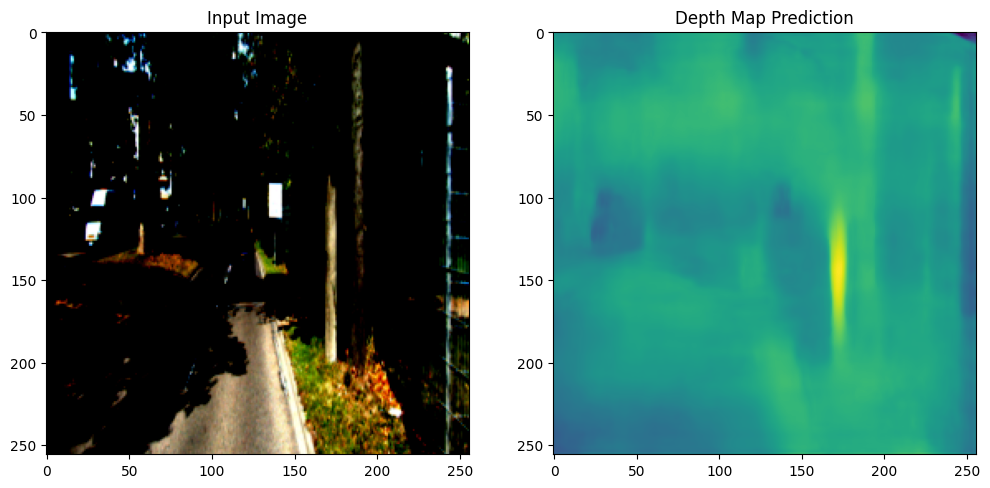

Inference Progress: 100%|██████████| 100/100 [01:11<00:00,  1.39batch/s]


Pruning Ratio: 0.12
Mean Absolute Error (MAE): 111.80407157897949
Root Mean Squared Error (RMSE): 112.41882804870606



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


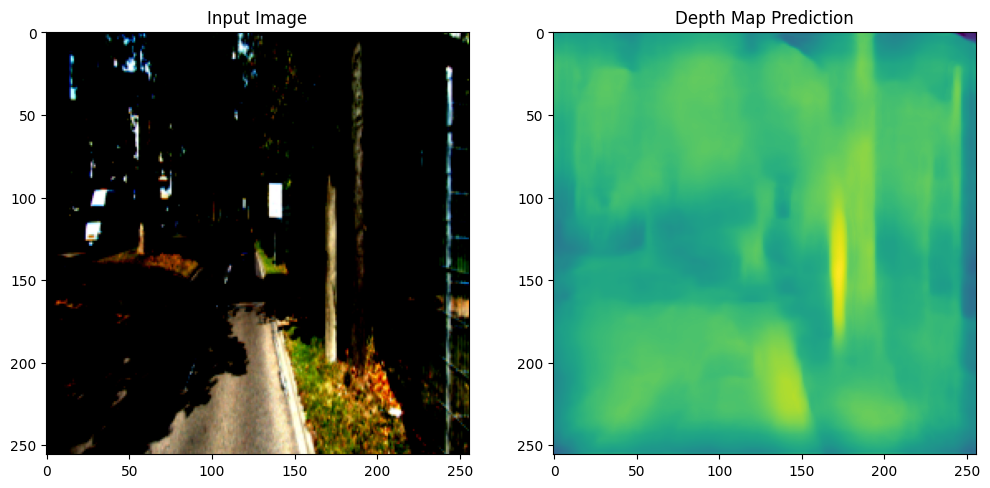

Inference Progress: 100%|██████████| 100/100 [01:09<00:00,  1.43batch/s]


Pruning Ratio: 0.14
Mean Absolute Error (MAE): 112.69289421081542
Root Mean Squared Error (RMSE): 113.15703353881835



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


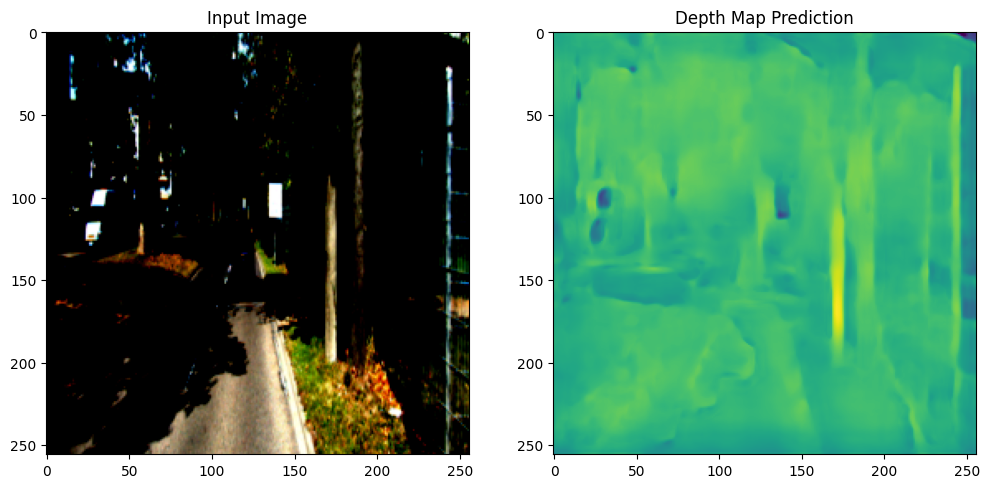

Inference Progress: 100%|██████████| 100/100 [01:10<00:00,  1.43batch/s]


Pruning Ratio: 0.16
Mean Absolute Error (MAE): 56.11233921051026
Root Mean Squared Error (RMSE): 56.5368270111084



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


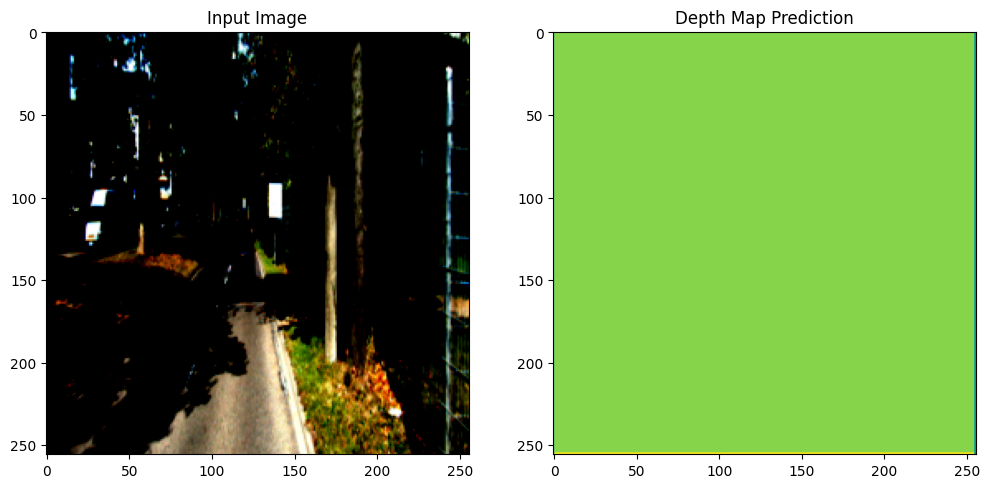

Inference Progress: 100%|██████████| 100/100 [01:08<00:00,  1.45batch/s]


Pruning Ratio: 0.18
Mean Absolute Error (MAE): 1.3342667543888092
Root Mean Squared Error (RMSE): 1.3344277453422546



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


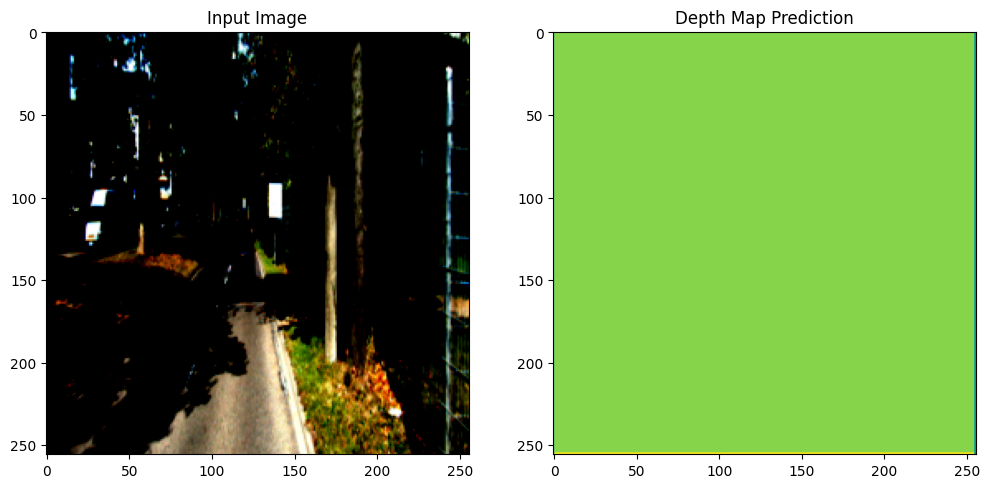

Inference Progress: 100%|██████████| 100/100 [01:08<00:00,  1.46batch/s]


Pruning Ratio: 0.2
Mean Absolute Error (MAE): 1.3342667543888092
Root Mean Squared Error (RMSE): 1.3344277453422546



In [17]:
# Channel pruning sparsities
pruning_percentages = [0.0, .02, .04, .06, .08, .10, .12, .14, .16, .18, .20]

for percentage in pruning_percentages:
    # Clone model and prune
    pruned_model = copy.deepcopy(midas)
    prune_model(model=pruned_model, percent=percentage)

    # Fine Tuning - Does Not Work
    #pruned_model = fine_tune_model(pruned_model, train_loader, val_loader, num_epochs=1, learning_rate=0.001)

    # Quantization - Does Not Work
    # quantized_model = quantize_model(pruned_model)
    # calibrate(quantized_model, train_loader)
    # quantized_model.eval()

    # Model Summary
    #summary(pruned_model, (3, 256, 256))

    # Compute Accuracy
    average_mae, average_rmse = compute_accuracy(pruned_model, val_loader, device)
    print(f"Pruning Ratio: {percentage}")
    print(f"Mean Absolute Error (MAE): {average_mae}")
    print(f"Root Mean Squared Error (RMSE): {average_rmse}")
    print()

    # Save Model
    torch.save(pruned_model.state_dict(), f"model_weights_channel_pruned_{percentage}.pth")

In [18]:
# Fine grain prune function
def fine_grain_prune(model, prune_percentage):
    # Fine grain prune all conv2d layers according to pruning percentage using torch
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.modules.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=prune_percentage)

Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


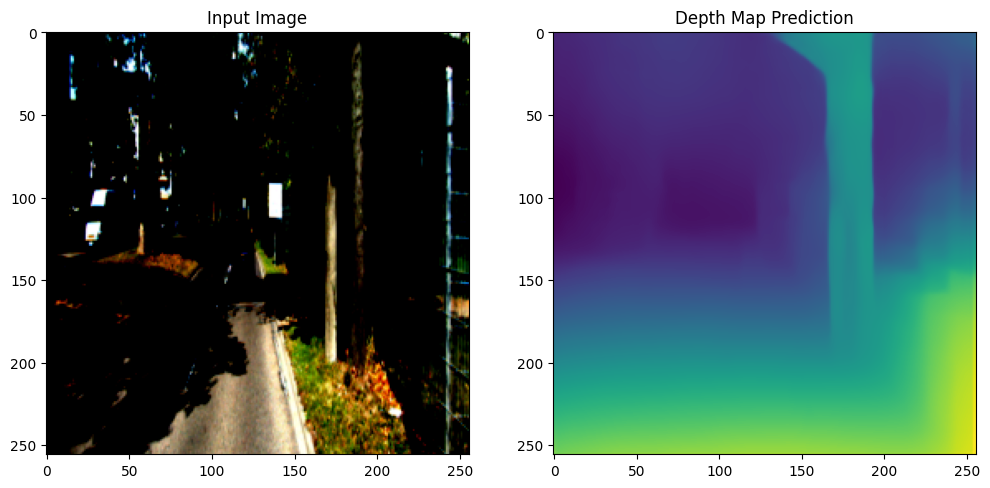

Inference Progress: 100%|██████████| 100/100 [01:08<00:00,  1.45batch/s]


Pruning Ratio: 0.0
Mean Absolute Error (MAE): 408.199885559082
Root Mean Squared Error (RMSE): 482.88056518554686



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


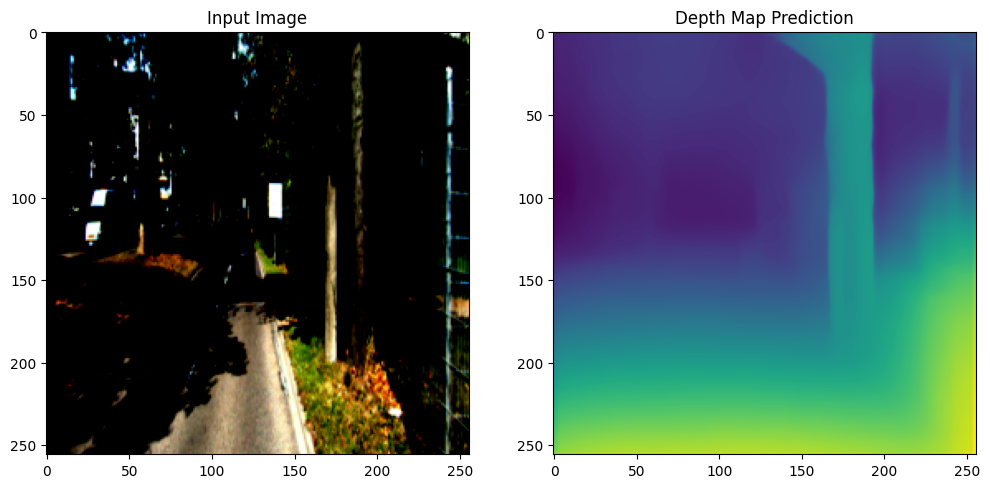

Inference Progress: 100%|██████████| 100/100 [01:08<00:00,  1.45batch/s]


Pruning Ratio: 0.1
Mean Absolute Error (MAE): 402.195693359375
Root Mean Squared Error (RMSE): 475.88753326416014



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


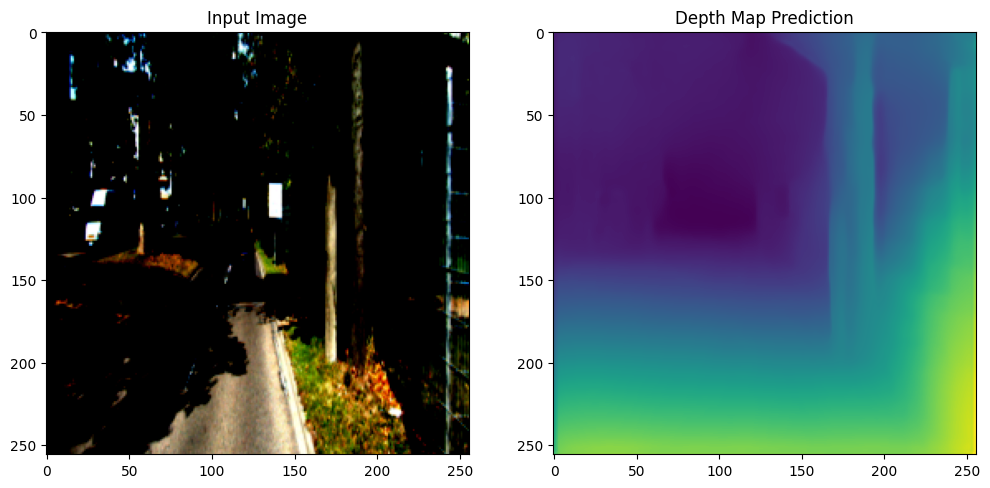

Inference Progress: 100%|██████████| 100/100 [01:10<00:00,  1.42batch/s]


Pruning Ratio: 0.2
Mean Absolute Error (MAE): 388.1726385498047
Root Mean Squared Error (RMSE): 452.3707125854492



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference Progress: 100%|██████████| 100/100 [01:09<00:00,  1.45batch/s]


Pruning Ratio: 0.3
Mean Absolute Error (MAE): 265.653133392334
Root Mean Squared Error (RMSE): 296.4854911804199



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


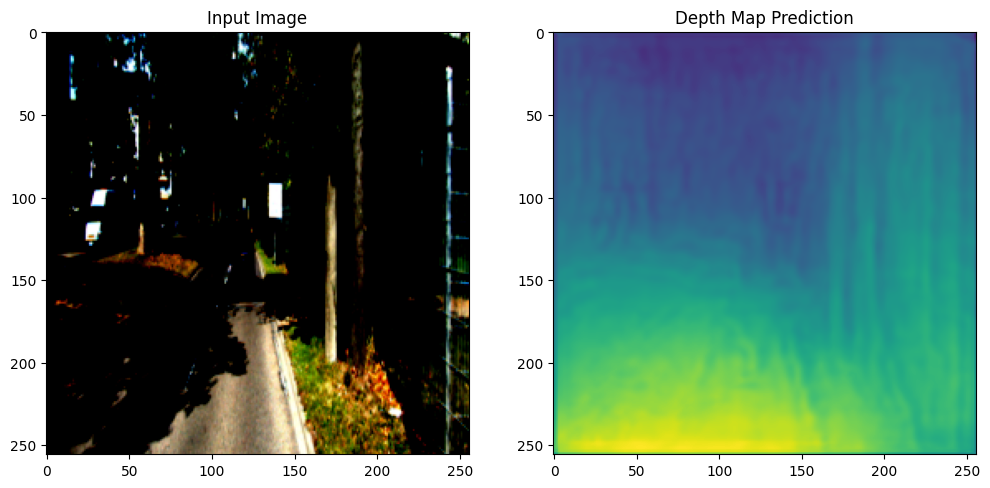

Inference Progress: 100%|██████████| 100/100 [01:10<00:00,  1.42batch/s]


Pruning Ratio: 0.4
Mean Absolute Error (MAE): 263.05264923095706
Root Mean Squared Error (RMSE): 274.13216842651366



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


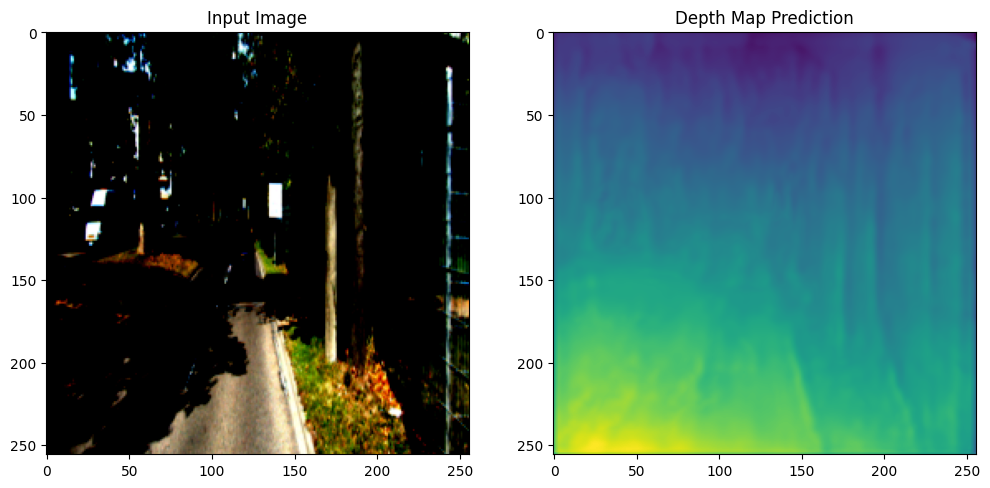

Inference Progress: 100%|██████████| 100/100 [01:08<00:00,  1.45batch/s]


Pruning Ratio: 0.5
Mean Absolute Error (MAE): 141.22775398254396
Root Mean Squared Error (RMSE): 148.50393142700196



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


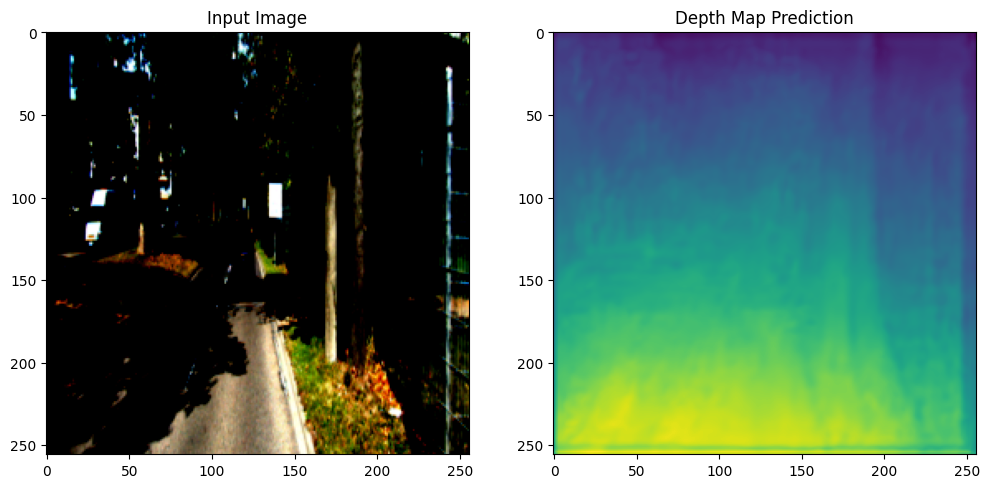

Inference Progress: 100%|██████████| 100/100 [01:09<00:00,  1.44batch/s]


Pruning Ratio: 0.6
Mean Absolute Error (MAE): 59.453567543029784
Root Mean Squared Error (RMSE): 63.272758102416994



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


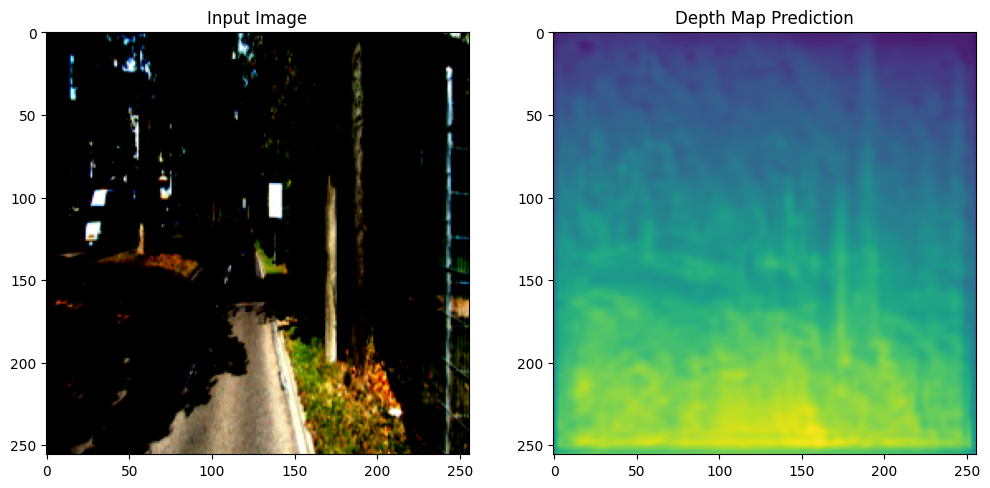

Inference Progress: 100%|██████████| 100/100 [01:09<00:00,  1.44batch/s]


Pruning Ratio: 0.7
Mean Absolute Error (MAE): 28.44746391296387
Root Mean Squared Error (RMSE): 30.235764694213866



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


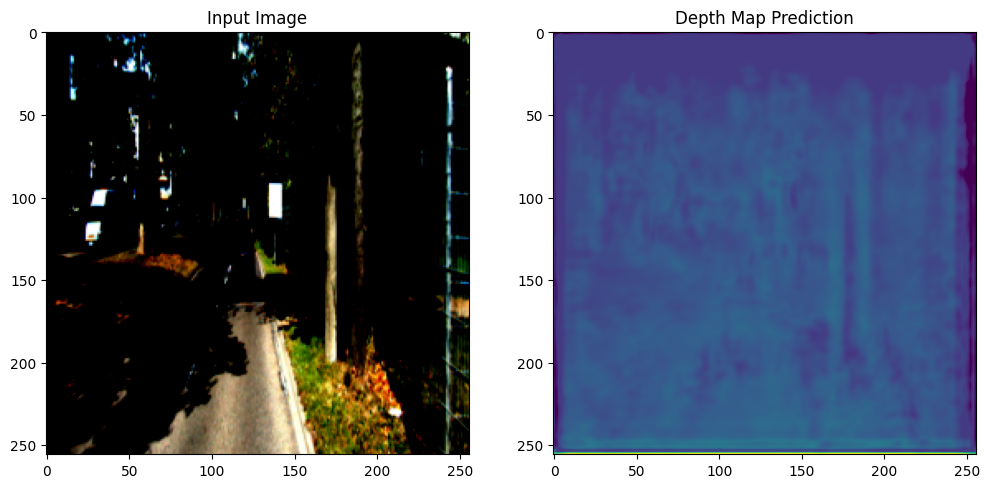

Inference Progress: 100%|██████████| 100/100 [01:13<00:00,  1.36batch/s]


Pruning Ratio: 0.8
Mean Absolute Error (MAE): 0.8254411947727204
Root Mean Squared Error (RMSE): 0.8608772498369217



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


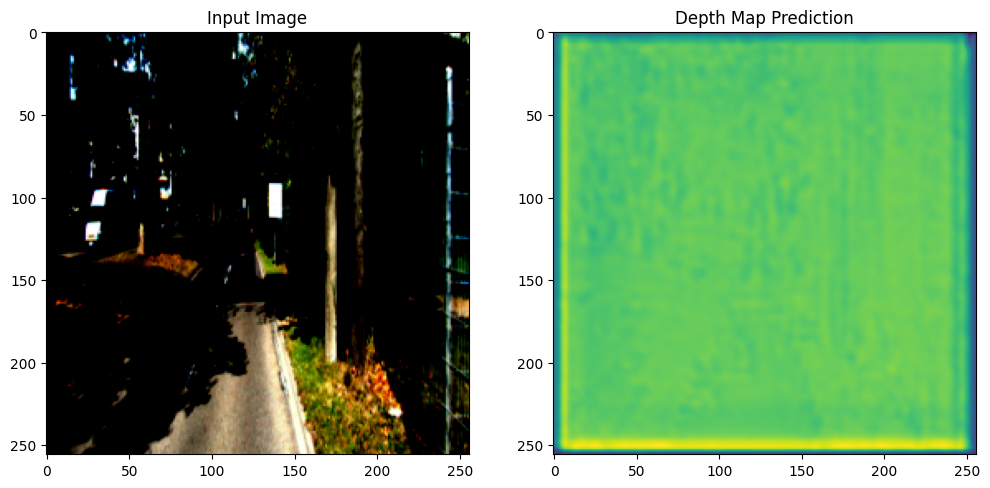

Inference Progress: 100%|██████████| 100/100 [01:10<00:00,  1.41batch/s]


Pruning Ratio: 0.9
Mean Absolute Error (MAE): 1.9117646872997285
Root Mean Squared Error (RMSE): 1.9207670593261719



Inference Progress:   0%|          | 0/100 [00:00<?, ?batch/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


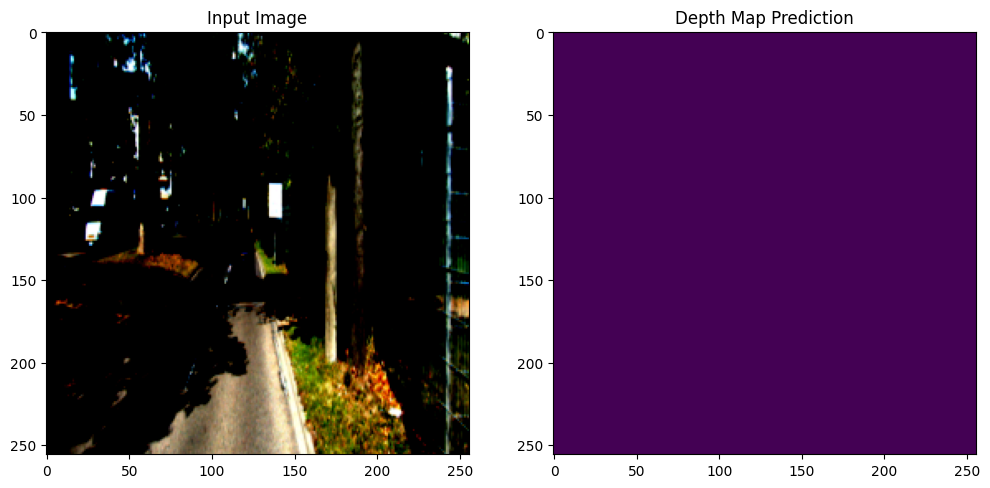

Inference Progress: 100%|██████████| 100/100 [01:10<00:00,  1.43batch/s]


Pruning Ratio: 0.99
Mean Absolute Error (MAE): 0.574961234331131
Root Mean Squared Error (RMSE): 0.5753219848871232



In [19]:
# Fine grained pruning sparsities
pruning_percentages = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, .90, 0.99]

for percentage in pruning_percentages:
    # Clone model and prune
    pruned_model = copy.deepcopy(midas)
    fine_grain_prune(model=pruned_model, prune_percentage=percentage)

    # Fine Tuning - Does Not Work
    #pruned_model = fine_tune_model(pruned_model, train_loader, val_loader, num_epochs=1, learning_rate=0.001)

    # Quantization - Does Not Work
    # quantized_model = quantize_model(pruned_model)
    # calibrate(quantized_model, train_loader)
    # quantized_model.eval()

    # Model Summary
    #summary(pruned_model, (3, 256, 256))

    # Compute Accuracy
    average_mae, average_rmse = compute_accuracy(pruned_model, val_loader, device)
    print(f"Pruning Ratio: {percentage}")
    print(f"Mean Absolute Error (MAE): {average_mae}")
    print(f"Root Mean Squared Error (RMSE): {average_rmse}")
    print()

    # Save Model
    torch.save(pruned_model.state_dict(), f"model_weights_fine_grain_pruned_{percentage}.pth")

In [ ]:
# Sparsity Predictions since torch summary won't give them for some reason
# Channel pruned
pruning_percentages = [0.0, .02, .04, .06, .08, .10, .12, .14, .16, .18, .20]
for percentage in pruning_percentages:
  print(f"Sparsity: {percentage}, Params: {(1.0-percentage)*16600929}")

# Fine grain pruned
pruning_percentages = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, .90, 0.99]
for percentage in pruning_percentages:
  print(f"Sparsity: {percentage}, Params: {(1.0-percentage)*16600929}")

Sparsity: 0.0, Params: 16600929.0
Sparsity: 0.02, Params: 16268910.42
Sparsity: 0.04, Params: 15936891.84
Sparsity: 0.06, Params: 15604873.26
Sparsity: 0.08, Params: 15272854.680000002
Sparsity: 0.1, Params: 14940836.1
Sparsity: 0.12, Params: 14608817.52
Sparsity: 0.14, Params: 14276798.94
Sparsity: 0.16, Params: 13944780.36
Sparsity: 0.18, Params: 13612761.780000001
Sparsity: 0.2, Params: 13280743.200000001
Sparsity: 0.0, Params: 16600929.0
Sparsity: 0.1, Params: 14940836.1
Sparsity: 0.2, Params: 13280743.200000001
Sparsity: 0.3, Params: 11620650.299999999
Sparsity: 0.4, Params: 9960557.4
Sparsity: 0.5, Params: 8300464.5
Sparsity: 0.6, Params: 6640371.600000001
Sparsity: 0.7, Params: 4980278.700000001
Sparsity: 0.8, Params: 3320185.7999999993
Sparsity: 0.9, Params: 1660092.8999999997
Sparsity: 0.99, Params: 166009.29000000015


In [ ]:
!pip install onnx
!pip install onnx-tf
!pip install torch onnx tf2onnx tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import onnx
import tensorflow as tf
import onnx_tf
import tf2onnx
from onnx import helper

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Convert Pytorch --> TensorFlow --> TFLite using ONNX, trial with single .pth file
midas.load_state_dict(torch.load('model_weights_channel_pruned_0.0.pth'))
midas.eval()
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Export PyTorch model to ONNX format
onnx_path = "model.onnx"
torch.onnx.export(midas, dummy_input, onnx_path, verbose=True)

In [ ]:
# Replace layer names causing finnicky error in .onnx file
# All code and comments in this cell directly from https://stackoverflow.com/questions/76839366/tf-rep-export-graphtf-model-path-keyerror-input-1

import onnx
from onnx import helper

onnx_model = onnx.load('model.onnx')

# Define a mapping from old names to new names
name_map = {"onnx::Pad_0": "onnx__Pad_0"}

# Initialize a list to hold the new inputs
new_inputs = []

# Iterate over the inputs and change their names if needed
for inp in onnx_model.graph.input:
    if inp.name in name_map:
        # Create a new ValueInfoProto with the new name
        new_inp = helper.make_tensor_value_info(name_map[inp.name],
                                                inp.type.tensor_type.elem_type,
                                                [dim.dim_value for dim in inp.type.tensor_type.shape.dim])
        new_inputs.append(new_inp)
    else:
        new_inputs.append(inp)

# Clear the old inputs and add the new ones
onnx_model.graph.ClearField("input")
onnx_model.graph.input.extend(new_inputs)

# Go through all nodes in the model and replace the old input name with the new one
for node in onnx_model.graph.node:
    for i, input_name in enumerate(node.input):
        if input_name in name_map:
            node.input[i] = name_map[input_name]

# Save the renamed ONNX model
onnx.save(onnx_model, 'model.onnx')

In [ ]:
# Does Not Work - conversion fails due to no support for squeeze version 13 and unsqueeze version 13
# Load ONNX model
onnx_model = onnx.load(onnx_path)
# Convert ONNX model to TensorFlow format
tf_rep = onnx_tf.backend.prepare(onnx_model)
# Export  TensorFlow  model
tf_rep.export_graph("onxx.tf")

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


BackendIsNotSupposedToImplementIt: ignored

In [ ]:
# Convert ONNX model to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("onxx.tf")
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)

In [ ]:
# Loop for ONNX conversion on channel pruned models
pruning_percentages = [0.0, .02, .04, .06, .08, .10, .12, .14, .16, .18, .20]
for percentage in pruning_percentages:
    # Convert Pytorch --> TensorFlow --> TFLite using ONNX
    midas.load_state_dict(torch.load(f"model_weights_fine_grain_pruned_{percentage}.pth"))
    midas.eval()
    dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Adjust input shape

    # ONNX Conversion Here
    # ...

    # Save TFLite model
    with open(f"model_weights_fine_grain_pruned_{percentage}.tflite", "wb") as f:
        f.write(tflite_model)

In [ ]:
# Loop for ONNX conversion on fine grain pruned models
pruning_percentages = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, .90, 0.99]
for percentage in pruning_percentages:
    # Convert Pytorch --> TensorFlow --> TFLite using ONNX
    midas.load_state_dict(torch.load(f"model_weights_channel_pruned_{percentage}.pth"))
    midas.eval()
    dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Adjust input shape

    # ONNX Conversion Here
    # ...

    # Save the TFLite model to a file
    with open(f"model_weights_channel_pruned_{percentage}.tflite", "wb") as f:
        f.write(tflite_model)